## Imports

# ECG Pattern Extraction - File name (Ecg Feature Extraction)

In [2]:
import scipy
import numpy as np
import pandas as pd
# !pip install tensorflow==2.15.0
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tensorflow.keras.models import load_model

## Loading

### Data

In [3]:
data_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_test.csv')
data_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_train.csv')
data_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_val.csv')

labels_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_test.csv')
labels_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_train.csv')
labels_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_val.csv')

## Create data generators

In [4]:
# This class is a customer data generator 
# It's purpose is to load, preprocess and supply data in batches during training
# It's there because it is inefficient to load large datasets at once
    
class ECG_DataGen(tf.keras.utils.Sequence):    
# Contructor - Takes a list of ECG files and labels, batch size (number of samples ), sample length (number of data points in each ECG signal), and an option to shuffle the data. 
    def __init__(self, df_files, df_labels, data_col, batch_size, sample_len, shuffle=True):
        #self is an instance of the class #it should be passed as first parameter in all methods
        
        self.df_files = df_files.copy()
        self.df_labels = df_labels.copy()
        self.data_col = data_col
        self.n_samples = len(self.df_files)
        self.sample_len = sample_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return self.n_samples // self.batch_size
    
#     applies low pass filter
    def low_pass_filter(self, voltages, window_size):
        """Applies a moving average low-pass filter to a 1D array of voltages."""
        # Create a windowed version of the array
        window = np.ones(window_size) / window_size
        filtered_voltages = np.convolve(voltages, window, mode='same')
        return filtered_voltages
    
#    normalizes data and apply low pass filter
    def scale(self, array):
        # Replace NaN values with 0.0
        array = np.nan_to_num(array, nan=0.0)
        
        #apply low pass filter
        array = self.low_pass_filter(array, window_size=100)

        # normalizing
        a_min = np.min(array)
        a_max = np.max(array)
        if a_max - a_min == 0:
            return np.zeros_like(array).reshape((-1, 1))
        return np.array((array - a_min) / (a_max - a_min))
       
#   TO BE SEARCHED  -  loads, preprocesses (filters and normalizes), and formats the data in chunks (batches) and returns it to the model.    
    def __getitem__(self, index):
        batch_leads = np.zeros((self.batch_size, self.sample_len, 12)) #create array with shape 128, 5000, 12
        batch_labels = np.zeros((self.batch_size, len(self.df_labels.columns))) 

        for i in range(index*self.batch_size, (index+1)*self.batch_size):

            # load the ECG signals
            leads = scipy.io.loadmat(self.df_files.at[i, self.data_col])['val'] #loadmat() is a function to load matlab files #self.df_files.at[i, self.data_col] is the file path
            
            for j, lead_data in enumerate(leads): #iterate through 12 leads
                #preprocess data (normalize, filter)
                scaled_lead_data = self.scale(lead_data)
                
                batch_leads[i - index*self.batch_size, :, j] = scaled_lead_data.reshape((-1,))
            batch_labels[i - index*self.batch_size] = self.df_labels.loc[i].values

        return batch_leads, batch_labels

    #  called at the end of every training epoch to shuffle data after every epoch
    def on_epoch_end(self):
        if self.shuffle: 
            shuffle_idx = np.random.choice(range(self.n_samples), size=self.n_samples, replace=False)
            self.df_files = self.df_files.iloc[shuffle_idx].reset_index(drop=True)
            self.df_labels = self.df_labels.iloc[shuffle_idx].reset_index(drop=True)

In [5]:
data_col = 'ecg_filename'
sample_len = 5000
batch_size= 128

# Create data generators (Objects from ECG_DataGen class)
# These generators do not store the data themselves; instead, they load, preprocess, and return batches of ECG data and corresponding labels during model training or evaluation.
train_gen = ECG_DataGen(data_train, labels_train, data_col, batch_size, sample_len)
val_gen = ECG_DataGen(data_val, labels_val, data_col, batch_size, sample_len)
test_gen = ECG_DataGen(data_test, labels_test, data_col, len(data_test), sample_len)

In [6]:
# Extract a batch of data
X, _ = train_gen.__getitem__(0)  # Get the first batch
X.shape

(128, 5000, 12)

In [7]:
# Select a subset of the data for explanation
X_sample = X[:10]  # Take first 10 samples as an example
X_sample.shape

(10, 5000, 12)

In [7]:
ecg_data = X[:1]
ecg_data.shape

(1, 5000, 12)

In [15]:
def extract_ecg_features(ecg_data):
    features = {}
    
    # Iterate over each lead
    for lead_idx in range(ecg_data.shape[1]):
        lead_data = ecg_data[:, lead_idx]
        lead_name = f'Lead {lead_idx + 1}'
        features[lead_name] = {}

        # Feature 1: R-R Intervals (using peak detection to identify R-peaks)
        r_peaks, _ = find_peaks(lead_data, distance=150)
        rr_intervals = np.diff(r_peaks) / 500.0  # Convert to seconds
        features[lead_name]['R_peaks'] = r_peaks
        features[lead_name]['RR_intervals'] = rr_intervals

        # Feature 2: ST-Segment Elevation/Depression
        st_segment_indices = (r_peaks + 80).astype(int)  # ST-segment occurs ~80 ms after R-peak
        st_segment_values = lead_data[st_segment_indices[st_segment_indices < len(lead_data)]]
        features[lead_name]['ST_segment'] = st_segment_values
        features[lead_name]['ST_elevation'] = np.mean(st_segment_values) > 0.1  # threshold for elevation/depression

        # Feature 3: QRS Duration (using width between Q and S points around R-peak)
        qrs_durations = []
        for r_peak in r_peaks:
            left_base = r_peak - 20 if r_peak - 20 > 0 else 0
            right_base = r_peak + 20 if r_peak + 20 < len(lead_data) else len(lead_data) - 1
            qrs_durations.append((right_base - left_base) / 500.0)  # duration in seconds
        features[lead_name]['QRS_duration'] = qrs_durations

        # Feature 4: T-wave Analysis (looking for T-wave peak after R-peak)
        t_peaks, _ = find_peaks(lead_data, distance=100, height=np.mean(lead_data))
        features[lead_name]['T_peaks'] = t_peaks

    return features

# Function to plot extracted features from ECG data
def plot_ecg_features(ecg_data, ecg_features):
    fig, axes = plt.subplots(4, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for lead_idx in range(ecg_data.shape[1]):
        lead_data = ecg_data[:, lead_idx]
        lead_name = f'Lead {lead_idx + 1}'
        lead_features = ecg_features[lead_name]

        ax = axes[lead_idx]
        ax.plot(lead_data, label='ECG Signal')
        
        # Plot R-peaks
        if 'R_peaks' in lead_features:
            ax.plot(lead_features['R_peaks'], lead_data[lead_features['R_peaks']], 'rx', label='R-peaks')
        
        # Plot ST-segment points
        if 'ST_segment' in lead_features:
            st_indices = lead_features['R_peaks'] + 80
            st_indices = st_indices[st_indices < len(lead_data)]
            ax.plot(st_indices, lead_features['ST_segment'], 'go', label='ST-segment')
        
        # Plot T-peaks
        if 'T_peaks' in lead_features:
            ax.plot(lead_features['T_peaks'], lead_data[lead_features['T_peaks']], 'mo', label='T-peaks')
        
        ax.set_title(f'ECG Features for {lead_name}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Amplitude')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
# Example usage
if __name__ == "__main__":
    # Mock ECG data with shape (5000, 12)
    # ecg_data_mock = np.random.randn(5000, 12)
    ecg_data_mock = ecg_data[0]
    ecg_features = extract_ecg_features(ecg_data_mock)

    # Print extracted features
    for lead, lead_features in ecg_features.items():
        print(f"{lead} Features:")
        for feature_name, value in lead_features.items():
            print(f"  {feature_name}: {value[:5] if isinstance(value, np.ndarray) or isinstance(value, list) else value}")

Lead 1 Features:
  R_peaks: [ 50 200 432 600 900]
  RR_intervals: [0.3   0.464 0.336 0.6   0.326]
  ST_segment: [0.86508413 0.63531651 0.68078926 0.48848157 0.7255609 ]
  ST_elevation: True
  QRS_duration: [0.08, 0.08, 0.08, 0.08, 0.08]
  T_peaks: [ 50 200 327 432 600]
Lead 2 Features:
  R_peaks: [ 50 202 383 669 864]
  RR_intervals: [0.304 0.362 0.572 0.39  0.558]
  ST_segment: [0.73481293 0.78977148 0.57638493 0.50910128 0.41800079]
  ST_elevation: True
  QRS_duration: [0.08, 0.08, 0.08, 0.08, 0.08]
  T_peaks: [ 50 202 383 503 669]
Lead 3 Features:
  R_peaks: [  53  204  671  830 1145]
  RR_intervals: [0.302 0.934 0.318 0.63  0.322]
  ST_segment: [0.65913445 0.8413727  0.67513806 0.37028063 0.66499493]
  ST_elevation: True
  QRS_duration: [0.08, 0.08, 0.08, 0.08, 0.08]
  T_peaks: [ 53 204 353 671 830]
Lead 4 Features:
  R_peaks: [  89  302  563  769 1056]
  RR_intervals: [0.426 0.522 0.412 0.574 0.374]
  ST_segment: [0.23270941 0.18160096 0.48393734 0.41145626 0.47477765]
  ST_elevat

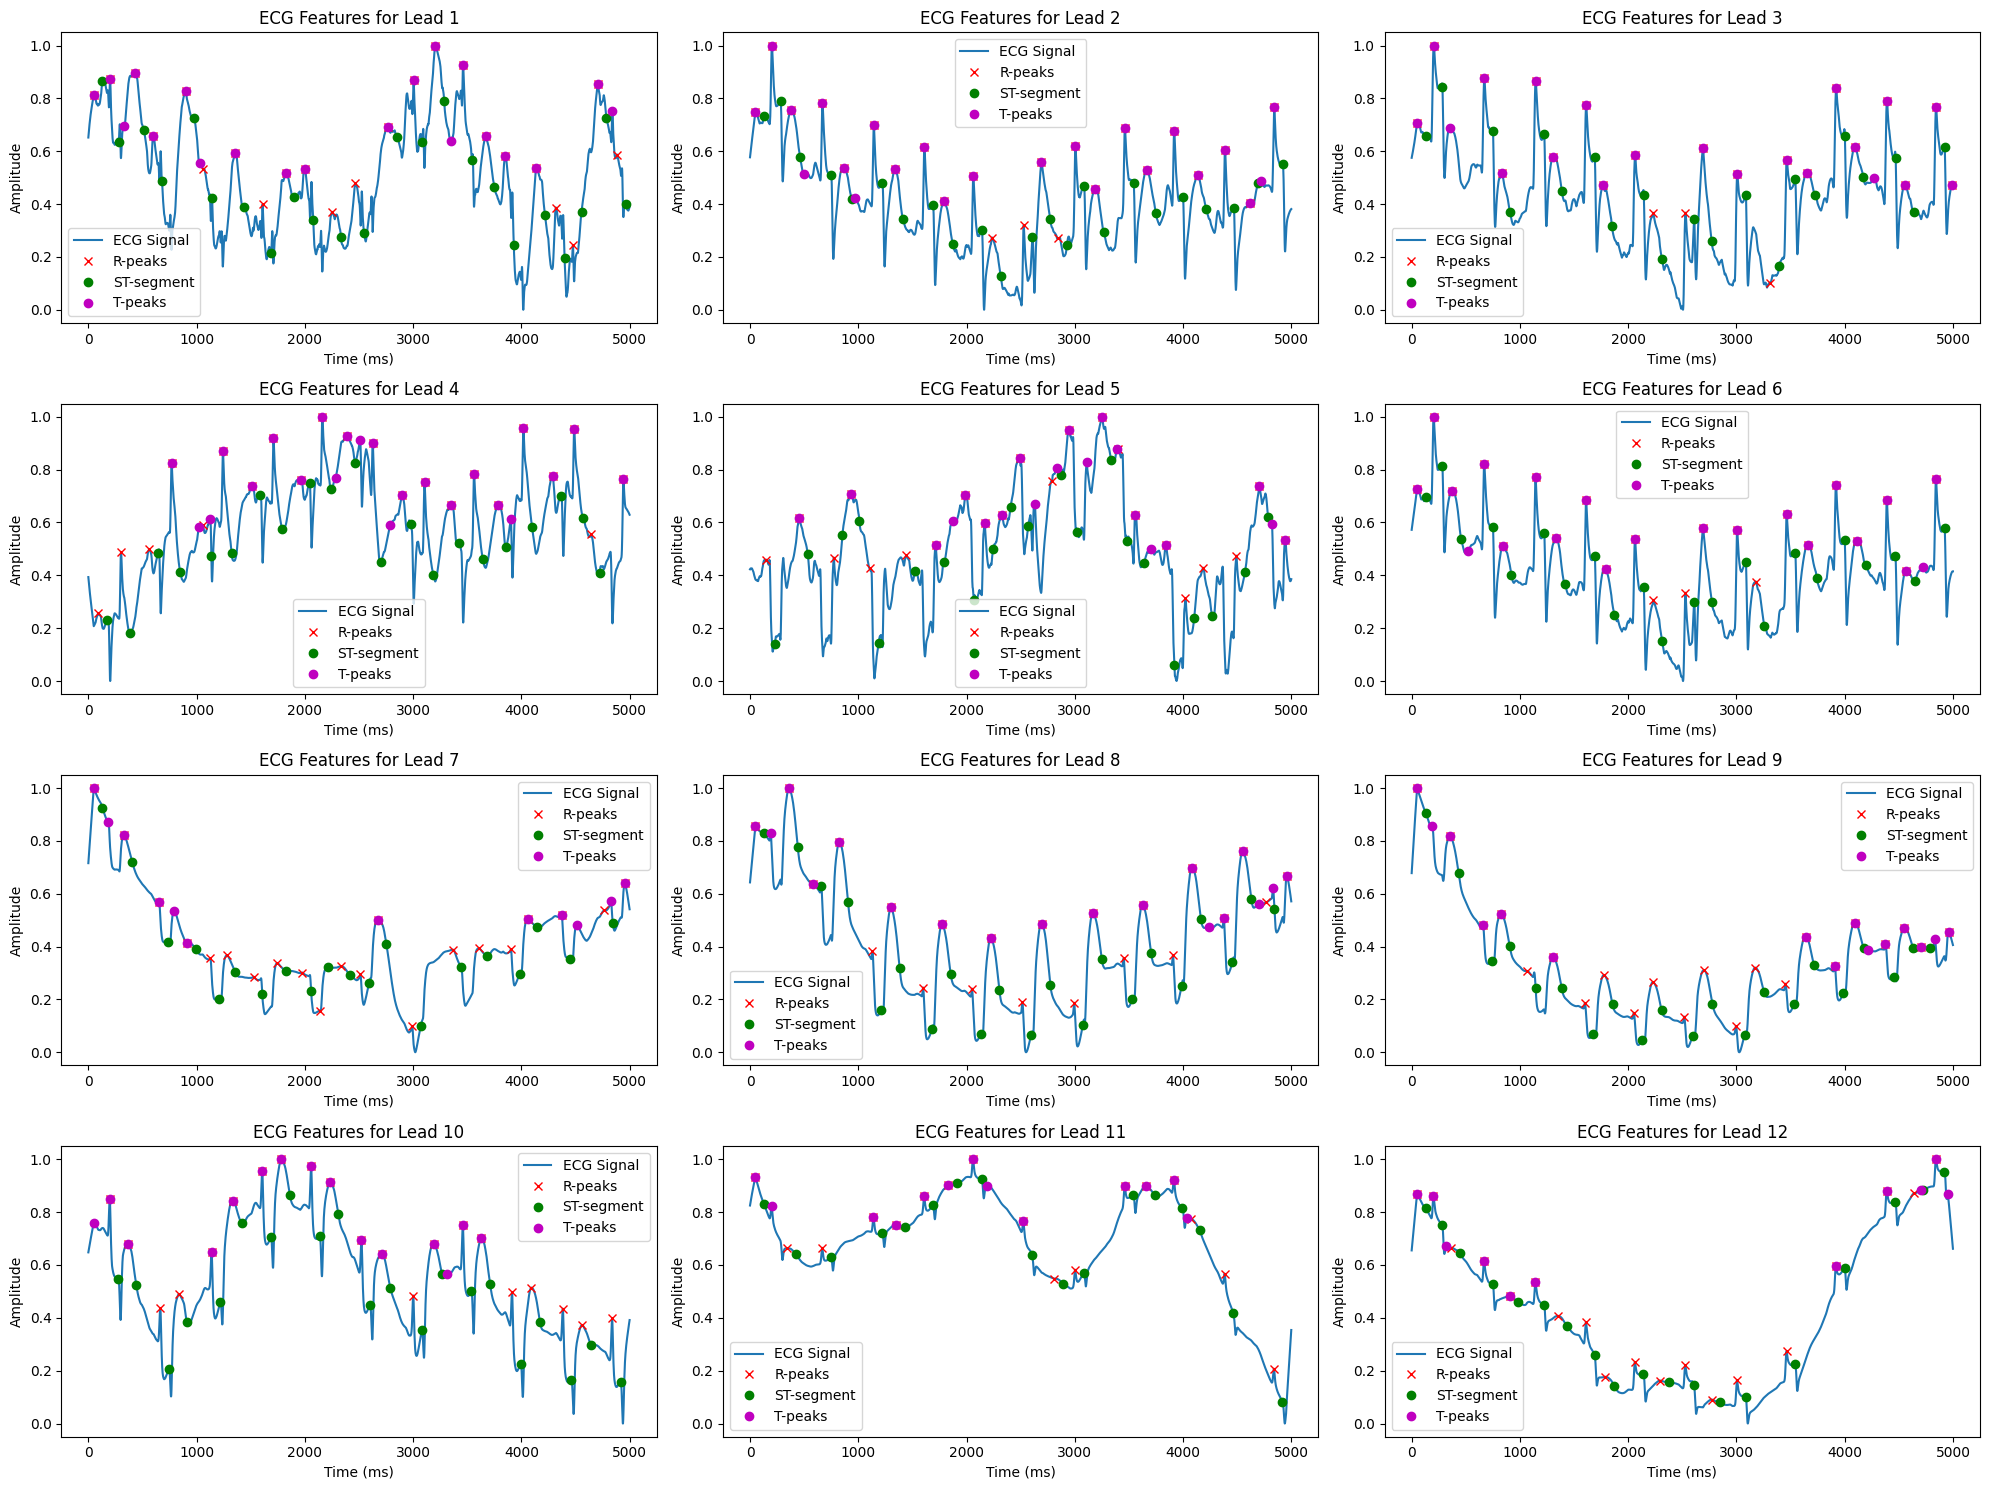

In [16]:
# Plot the features
plot_ecg_features(ecg_data_mock, ecg_features)